In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
shapes = cv2.imread('hough.jpg')
#cv2.imshow('Original Image', shapes)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
shapes_grayscale = cv2.cvtColor(shapes, cv2.COLOR_RGB2GRAY)


In [3]:
cv2.imshow('grayscale Image',shapes_grayscale )
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [4]:
shapes_blurred = cv2.GaussianBlur(shapes_grayscale, (5, 5), 1.5)

In [5]:
canny_edges = cv2.Canny(shapes_blurred, 100, 200)
cv2.imshow('Canny Edges', canny_edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes

    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas

In [7]:
def hough_simple_peaks(H, num_peaks):
    indices =  np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T


In [8]:
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size/2)
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size/2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size/2)
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size/2) + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(int(min_x),int( max_x)):
            for y in range(int(min_y), int(max_y)):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H

In [9]:
def plot_hough_acc(H, plot_title='Hough Accumulator Plot'):
   
    fig = plt.figure(figsize=(10, 10))
    fig.canvas.set_window_title(plot_title)

    plt.imshow(H, cmap='jet')

    plt.xlabel('Theta Direction'), plt.ylabel('Rho Direction')
    plt.tight_layout()
    plt.show()

In [10]:
def hough_lines_draw(img, indicies, rhos, thetas):
    
    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

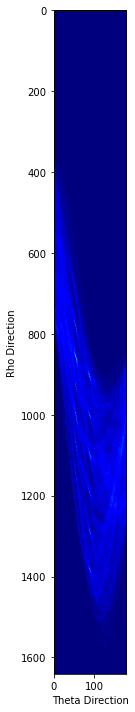

In [11]:
H, rhos, thetas = hough_lines_acc(canny_edges)
indicies, H = hough_peaks(H, 10, nhood_size=11) # find peaks
plot_hough_acc(H) # plot hough space, brighter spots have higher votes
hough_lines_draw(shapes, indicies, rhos, thetas)

# Show image with manual Hough Transform Lines
cv2.imshow('Major Lines: Manual Hough Transform', shapes)
cv2.waitKey(0)
cv2.destroyAllWindows()